In [7]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torchvision import transforms
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from torch.utils.data import DataLoader
from pathlib import Path

from data_preprocessing import *
from dataset import *
from utils import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device).requires_grad_(False)

In [4]:
def load_image(p):
    return Image.open(p).convert("RGB").resize((256, 256))

In [5]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     lambda x: x * 2.0 - 1.0
# ])
# data_to_latents(vae, "./images/train/", Path("./latent_images/train/"), transform=transform, batch_size=5)
# data_to_latents(vae, "./images/test/", Path("./latent_images/test/"), transform=transform, batch_size=5)


In [6]:
# train_dataloader = latent_dataloader(Path("./latent_images/train/"), batch_size=20, shuffle=True)
# test_dataloader = latent_dataloader(Path("./latent_images/test/"), batch_size=20, shuffle=True)

In [7]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     lambda x: x * 2.0 - 1.0
# ])
# data_to_latents(vae, "./politician/", Path("./politician_latents/"), transform=transform, batch_size=5)


In [8]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     lambda x: x * 2.0 - 1.0
# ])
# data_to_latents(vae, "./data/face/images/", Path("./data/face/latents/"), transform=transform, batch_size=5)


In [5]:
train_dataloader = latent_dataloader(Path("./data/face/latents/"), batch_size=20, shuffle=True)

In [12]:
# train_dataloader = latent_dataloader(Path("./politician_latents/"), batch_size=3, shuffle=True)

In [9]:
def latents_to_pil(latents):     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

torch.Size([20, 4, 32, 32])
20
torch.Size([20])
tensor([2, 0, 0, 2, 1])


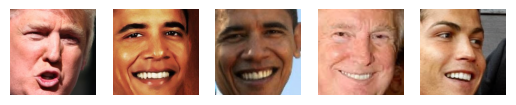

In [13]:
X, y = next(iter(train_dataloader))
print(X.shape)
print(X.shape[0])
print(y.shape)

images = latents_to_pil(X[:5].to(device))

fig = plt.figure()
print(y[:5])
for i in range(1, len(images)+1):
    fig.add_subplot(1, 5, i)
    plt.imshow(images[i-1])
    plt.axis("off")
plt.show()

In [6]:
unet = UNet2DModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D", 
        "AttnDownBlock2D", 
        "AttnDownBlock2D", 
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D", 
        "AttnUpBlock2D", 
        "UpBlock2D"
    ),
    class_embed_type="timestep"
).to(device)

In [15]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(dl))
# scheduler.step()

In [16]:
lr = 1e-3
loss_fn = nn.MSELoss()
optimizer = AdamW(unet.parameters(), lr=lr)
ddpm_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)
train_losses, test_losses = [], []
train_loss, test_loss = [], []

def train(model, epochs=None):
    for epoch in range(epochs):
        train_running_loss, test_running_loss = 0, 0
        model.train()
        for latent_images, labels in train_dataloader:
            latent_images = latent_images.to(device)
            labels = labels.to(device)

            timesteps = torch.randint(0, ddpm_scheduler.config.num_train_timesteps, (latent_images.shape[0], )).to(device)
            noise = torch.randn(latent_images.shape).to(device)
            noisy_images = ddpm_scheduler.add_noise(latent_images, noise, timesteps)

            pred_noise = model(noisy_images, timesteps, labels).sample

            loss = loss_fn(pred_noise, noise)
            train_losses.append(loss.item())
            train_running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # model.eval()
        # with torch.inference_mode():
        #     for latent_images, labels in train_dataloader:
        #         latent_images = latent_images.to(device)
        #         labels = labels.to(device)

        #         timesteps = torch.randint(0, ddpm_scheduler.config.num_train_timesteps, (latent_images.shape[0], )).to(device)
        #         noise = torch.randn_like(latent_images).to(device)
        #         noisy_images = ddpm_scheduler.add_noise(latent_images, noise, timesteps)

        #         pred_noise = model(noisy_images, timesteps, labels).sample

        #         loss = loss_fn(pred_noise, noise)
        #         test_losses.append(loss.item())
        #         test_running_loss += loss.item()

        train_loss.append(train_running_loss)
        # test_loss.append(test_running_loss)
        print(f"Epoch={epoch} | Train Loss: {train_running_loss/len(train_dataloader)}")
        # print(f"Epoch={epoch} | Train Loss: {train_running_loss/len(train_dataloader)} | Test Loss: {test_running_loss/len(test_dataloader)}")

        if epoch % 10 == 0:
            model.eval()
            noisy_images = torch.randn((5, 4, 32, 32)).to(device)
            labels = torch.randint(3, size=(noisy_images[:5].shape[0],)).to(device)

            for timestep in ddpm_scheduler.timesteps:
                with torch.inference_mode():
                    noise = model(noisy_images, timestep, labels).sample
                noisy_images = ddpm_scheduler.step(noise, timestep, noisy_images).prev_sample

            images = latents_to_pil(noisy_images)
            fig = plt.figure()
            print(labels)
            for i in range(1, len(images)+1):
                fig.add_subplot(1, 5, i)
                plt.imshow(images[i-1])
                plt.axis("off")
            plt.show()        

Epoch=0 | Train Loss: 0.6776429563760757
tensor([1, 2, 1, 2, 1], device='cuda:0')


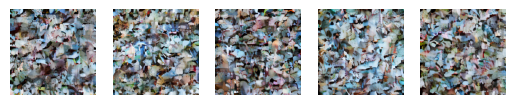

Epoch=1 | Train Loss: 0.409645177423954
Epoch=2 | Train Loss: 0.3090522661805153
Epoch=3 | Train Loss: 0.291366970166564
Epoch=4 | Train Loss: 0.27945671789348125
Epoch=5 | Train Loss: 0.24631953984498978
Epoch=6 | Train Loss: 0.23802020587027073
Epoch=7 | Train Loss: 0.2261364609003067
Epoch=8 | Train Loss: 0.2035687668249011
Epoch=9 | Train Loss: 0.23758981004357338
Epoch=10 | Train Loss: 0.18320485670119524
tensor([2, 2, 2, 1, 0], device='cuda:0')


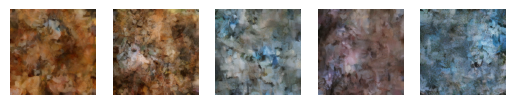

Epoch=11 | Train Loss: 0.1922248024493456
Epoch=12 | Train Loss: 0.1799140851944685
Epoch=13 | Train Loss: 0.24587621539831161
Epoch=14 | Train Loss: 0.19477694481611252
Epoch=15 | Train Loss: 0.1657801391556859
Epoch=16 | Train Loss: 0.19639148376882076
Epoch=17 | Train Loss: 0.19944989494979382
Epoch=18 | Train Loss: 0.20351922046393156
Epoch=19 | Train Loss: 0.20611917227506638
Epoch=20 | Train Loss: 0.16095624398440123
tensor([1, 0, 0, 1, 1], device='cuda:0')


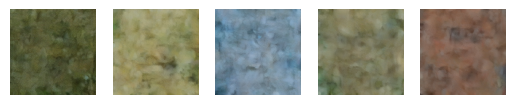

Epoch=21 | Train Loss: 0.16550145484507084
Epoch=22 | Train Loss: 0.18559402786195278
Epoch=23 | Train Loss: 0.19961147103458643
Epoch=24 | Train Loss: 0.19380823988467455
Epoch=25 | Train Loss: 0.19836875051259995
Epoch=26 | Train Loss: 0.1717261988669634
Epoch=27 | Train Loss: 0.15656956005841494
Epoch=28 | Train Loss: 0.2113062897697091
Epoch=29 | Train Loss: 0.2080735918134451
Epoch=30 | Train Loss: 0.19388385768979788
tensor([2, 1, 1, 0, 1], device='cuda:0')


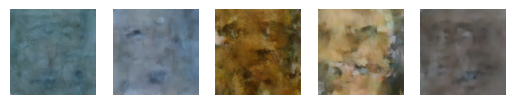

Epoch=31 | Train Loss: 0.20151017978787422
Epoch=32 | Train Loss: 0.15157384984195232
Epoch=33 | Train Loss: 0.18950276728719473
Epoch=34 | Train Loss: 0.22198718413710594
Epoch=35 | Train Loss: 0.19020142126828432
Epoch=36 | Train Loss: 0.15394291374832392
Epoch=37 | Train Loss: 0.16807883698493242
Epoch=38 | Train Loss: 0.1648565111681819
Epoch=39 | Train Loss: 0.16521509317681193
Epoch=40 | Train Loss: 0.17066028248518705
tensor([2, 2, 2, 1, 0], device='cuda:0')


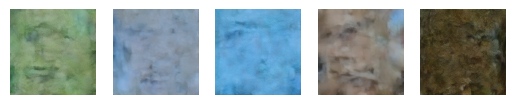

Epoch=41 | Train Loss: 0.15520355012267828
Epoch=42 | Train Loss: 0.1615484757348895
Epoch=43 | Train Loss: 0.1769676562398672
Epoch=44 | Train Loss: 0.21873298659920692
Epoch=45 | Train Loss: 0.17400890588760376
Epoch=46 | Train Loss: 0.1511926157400012
Epoch=47 | Train Loss: 0.15119346138089895
Epoch=48 | Train Loss: 0.18554541002959013
Epoch=49 | Train Loss: 0.14720803499221802
Epoch=50 | Train Loss: 0.13549714721739292
tensor([1, 0, 1, 1, 2], device='cuda:0')


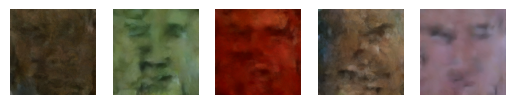

Epoch=51 | Train Loss: 0.1548051480203867
Epoch=52 | Train Loss: 0.18858226016163826
Epoch=53 | Train Loss: 0.15689232014119625
Epoch=54 | Train Loss: 0.1583174103870988
Epoch=55 | Train Loss: 0.14468861557543278
Epoch=56 | Train Loss: 0.163012083619833
Epoch=57 | Train Loss: 0.15951300971210003
Epoch=58 | Train Loss: 0.1681386949494481
Epoch=59 | Train Loss: 0.1289943028241396
Epoch=60 | Train Loss: 0.19148872420191765
tensor([2, 1, 2, 1, 0], device='cuda:0')


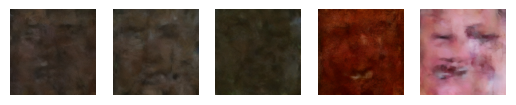

Epoch=61 | Train Loss: 0.16367735713720322
Epoch=62 | Train Loss: 0.1532239569351077
Epoch=63 | Train Loss: 0.1392201827839017
Epoch=64 | Train Loss: 0.19351073820143938
Epoch=65 | Train Loss: 0.1667374186217785
Epoch=66 | Train Loss: 0.1725823823362589
Epoch=67 | Train Loss: 0.148044943343848
Epoch=68 | Train Loss: 0.17107449658215046
Epoch=69 | Train Loss: 0.183737906627357
Epoch=70 | Train Loss: 0.16923263389617205
tensor([0, 1, 2, 0, 1], device='cuda:0')


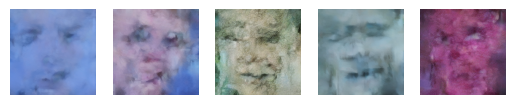

Epoch=71 | Train Loss: 0.13963607884943485
Epoch=72 | Train Loss: 0.14604871440678835
Epoch=73 | Train Loss: 0.20214370638132095
Epoch=74 | Train Loss: 0.18284445349127054
Epoch=75 | Train Loss: 0.15819371212273836
Epoch=76 | Train Loss: 0.17493805941194296
Epoch=77 | Train Loss: 0.1754383323714137
Epoch=78 | Train Loss: 0.16800875402987003
Epoch=79 | Train Loss: 0.1325961477123201
Epoch=80 | Train Loss: 0.15833223704248667
tensor([2, 1, 2, 0, 0], device='cuda:0')


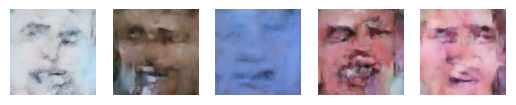

Epoch=81 | Train Loss: 0.15395825169980526
Epoch=82 | Train Loss: 0.1711523151025176
Epoch=83 | Train Loss: 0.11528293834999204
Epoch=84 | Train Loss: 0.18670347705483437
Epoch=85 | Train Loss: 0.16984820645302534
Epoch=86 | Train Loss: 0.1743266130797565
Epoch=87 | Train Loss: 0.1857701987028122
Epoch=88 | Train Loss: 0.16544448025524616
Epoch=89 | Train Loss: 0.14503767248243093
Epoch=90 | Train Loss: 0.16566086746752262
tensor([1, 0, 2, 0, 0], device='cuda:0')


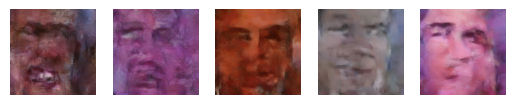

Epoch=91 | Train Loss: 0.15115139819681644
Epoch=92 | Train Loss: 0.14664573408663273
Epoch=93 | Train Loss: 0.16829846054315567
Epoch=94 | Train Loss: 0.18792291171848774
Epoch=95 | Train Loss: 0.17633815854787827
Epoch=96 | Train Loss: 0.162004504352808
Epoch=97 | Train Loss: 0.1636316953226924
Epoch=98 | Train Loss: 0.1426297901198268
Epoch=99 | Train Loss: 0.14589662291109562
Epoch=100 | Train Loss: 0.1546117877587676
tensor([0, 1, 2, 1, 1], device='cuda:0')


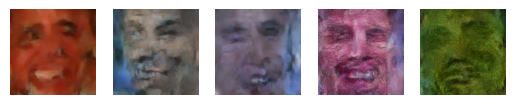

Epoch=101 | Train Loss: 0.20825117640197277
Epoch=102 | Train Loss: 0.1387943932786584
Epoch=103 | Train Loss: 0.1494594938121736
Epoch=104 | Train Loss: 0.17762847151607275
Epoch=105 | Train Loss: 0.16067860927432775
Epoch=106 | Train Loss: 0.18626588489860296
Epoch=107 | Train Loss: 0.13333954801782966
Epoch=108 | Train Loss: 0.146266121417284
Epoch=109 | Train Loss: 0.14722553733736277
Epoch=110 | Train Loss: 0.17408100422471762
tensor([2, 2, 1, 1, 1], device='cuda:0')


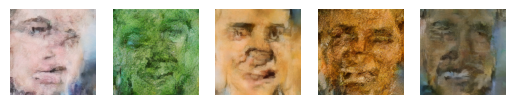

Epoch=111 | Train Loss: 0.1777873570099473
Epoch=112 | Train Loss: 0.21087248623371124
Epoch=113 | Train Loss: 0.13660942018032074
Epoch=114 | Train Loss: 0.14930319786071777
Epoch=115 | Train Loss: 0.18039216380566359
Epoch=116 | Train Loss: 0.12239996623247862
Epoch=117 | Train Loss: 0.13259970862418413
Epoch=118 | Train Loss: 0.1407514913007617
Epoch=119 | Train Loss: 0.12931928085163236
Epoch=120 | Train Loss: 0.16237684525549412
tensor([1, 2, 1, 1, 1], device='cuda:0')


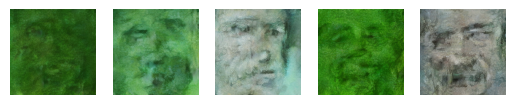

Epoch=121 | Train Loss: 0.1742702443152666
Epoch=122 | Train Loss: 0.1664574956521392
Epoch=123 | Train Loss: 0.16249781288206577
Epoch=124 | Train Loss: 0.15181500744074583
Epoch=125 | Train Loss: 0.15445138420909643
Epoch=126 | Train Loss: 0.13026875257492065
Epoch=127 | Train Loss: 0.15711926482617855
Epoch=128 | Train Loss: 0.16927862539887428
Epoch=129 | Train Loss: 0.17584201134741306
Epoch=130 | Train Loss: 0.17467608768492937
tensor([1, 2, 2, 2, 1], device='cuda:0')


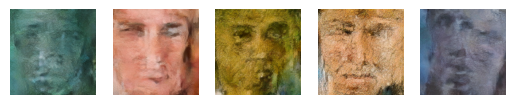

Epoch=131 | Train Loss: 0.15356871765106916
Epoch=132 | Train Loss: 0.20281525701284409
Epoch=133 | Train Loss: 0.13518797000870109
Epoch=134 | Train Loss: 0.18585482891649008
Epoch=135 | Train Loss: 0.1254713931120932
Epoch=136 | Train Loss: 0.14785938896238804
Epoch=137 | Train Loss: 0.15123909013345838
Epoch=138 | Train Loss: 0.14632697543129325
Epoch=139 | Train Loss: 0.1553501645103097
Epoch=140 | Train Loss: 0.1678951308131218
tensor([2, 2, 1, 2, 1], device='cuda:0')


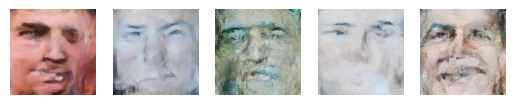

Epoch=141 | Train Loss: 0.1349087399430573
Epoch=142 | Train Loss: 0.17381678242236376
Epoch=143 | Train Loss: 0.12896802555769682
Epoch=144 | Train Loss: 0.16757354559376836
Epoch=145 | Train Loss: 0.17011042591184378
Epoch=146 | Train Loss: 0.14809516724199057
Epoch=147 | Train Loss: 0.14139397256076336
Epoch=148 | Train Loss: 0.1421408485621214
Epoch=149 | Train Loss: 0.13574814703315496
Epoch=150 | Train Loss: 0.15202463418245316
tensor([1, 1, 1, 0, 2], device='cuda:0')


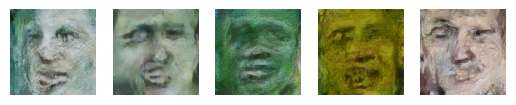

Epoch=151 | Train Loss: 0.1095376554876566
Epoch=152 | Train Loss: 0.1476071309298277
Epoch=153 | Train Loss: 0.15945565793663263
Epoch=154 | Train Loss: 0.1658300580456853
Epoch=155 | Train Loss: 0.18069920223206282
Epoch=156 | Train Loss: 0.13953849021345377
Epoch=157 | Train Loss: 0.12622910318896174
Epoch=158 | Train Loss: 0.17486836900934577
Epoch=159 | Train Loss: 0.17430248018354177
Epoch=160 | Train Loss: 0.1567460889928043
tensor([1, 2, 0, 1, 1], device='cuda:0')


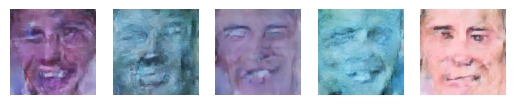

Epoch=161 | Train Loss: 0.1599338473752141
Epoch=162 | Train Loss: 0.16459081321954727
Epoch=163 | Train Loss: 0.1519780158996582
Epoch=164 | Train Loss: 0.1713348524644971
Epoch=165 | Train Loss: 0.1587306447327137
Epoch=166 | Train Loss: 0.18463575653731823
Epoch=167 | Train Loss: 0.15079478546977043
Epoch=168 | Train Loss: 0.16231145896017551
Epoch=169 | Train Loss: 0.14293873216956854
Epoch=170 | Train Loss: 0.14357154117897153
tensor([0, 0, 1, 0, 0], device='cuda:0')


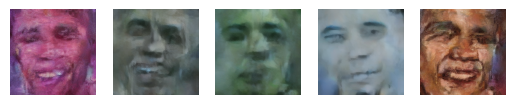

Epoch=171 | Train Loss: 0.13530719093978405
Epoch=172 | Train Loss: 0.12526487838476896
Epoch=173 | Train Loss: 0.16559802368283272
Epoch=174 | Train Loss: 0.1892043687403202
Epoch=175 | Train Loss: 0.16505821608006954
Epoch=176 | Train Loss: 0.13405477162450552
Epoch=177 | Train Loss: 0.13384816609323025
Epoch=178 | Train Loss: 0.12513848580420017
Epoch=179 | Train Loss: 0.1592768430709839
Epoch=180 | Train Loss: 0.11950959963724017
tensor([2, 2, 1, 2, 2], device='cuda:0')


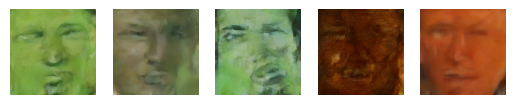

Epoch=181 | Train Loss: 0.1511182114481926
Epoch=182 | Train Loss: 0.16114237438887358
Epoch=183 | Train Loss: 0.1531868507154286
Epoch=184 | Train Loss: 0.12823660764843225
Epoch=185 | Train Loss: 0.15546130668371916
Epoch=186 | Train Loss: 0.17926417384296656
Epoch=187 | Train Loss: 0.11856007669121027
Epoch=188 | Train Loss: 0.15871407371014357
Epoch=189 | Train Loss: 0.15655240882188082
Epoch=190 | Train Loss: 0.14885516185313463
tensor([2, 1, 2, 0, 2], device='cuda:0')


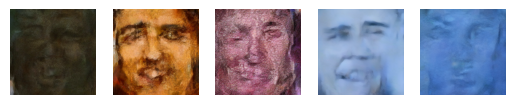

Epoch=191 | Train Loss: 0.18829269241541624
Epoch=192 | Train Loss: 0.1318263402208686
Epoch=193 | Train Loss: 0.1362092001363635
Epoch=194 | Train Loss: 0.150659398175776
Epoch=195 | Train Loss: 0.1520530404523015
Epoch=196 | Train Loss: 0.1540921265259385
Epoch=197 | Train Loss: 0.14024575054645538
Epoch=198 | Train Loss: 0.12478087190538645
Epoch=199 | Train Loss: 0.11952085932716727
Epoch=200 | Train Loss: 0.15252648759633303
tensor([0, 1, 0, 1, 0], device='cuda:0')


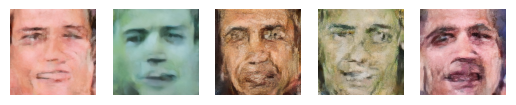

Epoch=201 | Train Loss: 0.16316986549645662
Epoch=202 | Train Loss: 0.11908640759065747
Epoch=203 | Train Loss: 0.14184887893497944
Epoch=204 | Train Loss: 0.1777898045256734
Epoch=205 | Train Loss: 0.14004890713840723
Epoch=206 | Train Loss: 0.13615523744374514
Epoch=207 | Train Loss: 0.14291485212743282
Epoch=208 | Train Loss: 0.1689910739660263
Epoch=209 | Train Loss: 0.13419686071574688
Epoch=210 | Train Loss: 0.10974828340113163
tensor([0, 2, 2, 1, 0], device='cuda:0')


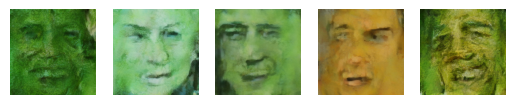

Epoch=211 | Train Loss: 0.14816970098763704
Epoch=212 | Train Loss: 0.11812001978978515
Epoch=213 | Train Loss: 0.1573119624517858
Epoch=214 | Train Loss: 0.1495851520448923
Epoch=215 | Train Loss: 0.1651070537045598
Epoch=216 | Train Loss: 0.13801055401563644
Epoch=217 | Train Loss: 0.13382731191813946
Epoch=218 | Train Loss: 0.14245741069316864
Epoch=219 | Train Loss: 0.1502408841624856
Epoch=220 | Train Loss: 0.14631961099803448
tensor([1, 0, 0, 1, 0], device='cuda:0')


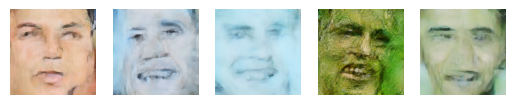

Epoch=221 | Train Loss: 0.13076078612357378
Epoch=222 | Train Loss: 0.18724250700324774
Epoch=223 | Train Loss: 0.13883529976010323
Epoch=224 | Train Loss: 0.13431771099567413
Epoch=225 | Train Loss: 0.13461326528340578
Epoch=226 | Train Loss: 0.1098509025759995
Epoch=227 | Train Loss: 0.13206241466104984
Epoch=228 | Train Loss: 0.1766586946323514
Epoch=229 | Train Loss: 0.1143441372551024
Epoch=230 | Train Loss: 0.1582939038053155
tensor([0, 2, 0, 0, 0], device='cuda:0')


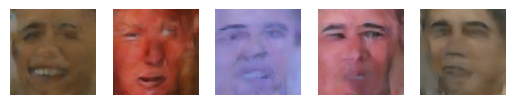

Epoch=231 | Train Loss: 0.1357368752360344
Epoch=232 | Train Loss: 0.12438692525029182
Epoch=233 | Train Loss: 0.14779884740710258
Epoch=234 | Train Loss: 0.15918037993833423
Epoch=235 | Train Loss: 0.12910080049186945
Epoch=236 | Train Loss: 0.15304276999086142
Epoch=237 | Train Loss: 0.19144686218351126
Epoch=238 | Train Loss: 0.13046486116945744
Epoch=239 | Train Loss: 0.12444736063480377
Epoch=240 | Train Loss: 0.1335565005429089
tensor([2, 1, 0, 2, 2], device='cuda:0')


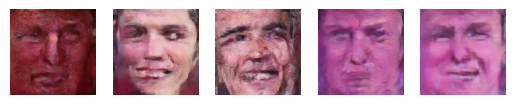

Epoch=241 | Train Loss: 0.14764996524900198
Epoch=242 | Train Loss: 0.18598200753331184
Epoch=243 | Train Loss: 0.14023551205173135
Epoch=244 | Train Loss: 0.15394463762640953
Epoch=245 | Train Loss: 0.15251794923096895
Epoch=246 | Train Loss: 0.10999166872352362
Epoch=247 | Train Loss: 0.1476494027301669
Epoch=248 | Train Loss: 0.1881321780383587
Epoch=249 | Train Loss: 0.1231982633471489
Epoch=250 | Train Loss: 0.16538917738944292
tensor([0, 1, 2, 2, 1], device='cuda:0')


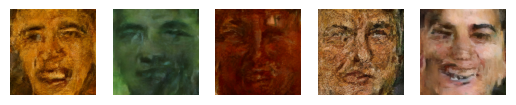

Epoch=251 | Train Loss: 0.14056138251908123
Epoch=252 | Train Loss: 0.13694687327370048
Epoch=253 | Train Loss: 0.13139430829323828
Epoch=254 | Train Loss: 0.14580864366143942
Epoch=255 | Train Loss: 0.12820026278495789
Epoch=256 | Train Loss: 0.1701638037338853
Epoch=257 | Train Loss: 0.13484635762870312
Epoch=258 | Train Loss: 0.12890437431633472
Epoch=259 | Train Loss: 0.16632711421698332
Epoch=260 | Train Loss: 0.17277301754802465
tensor([1, 2, 1, 2, 1], device='cuda:0')


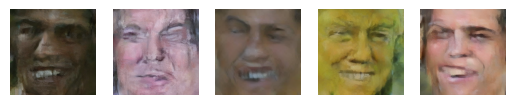

Epoch=261 | Train Loss: 0.1331113800406456
Epoch=262 | Train Loss: 0.12672481453046203
Epoch=263 | Train Loss: 0.18005789909511805
Epoch=264 | Train Loss: 0.1462417161092162
Epoch=265 | Train Loss: 0.16746882675215602
Epoch=266 | Train Loss: 0.13591337483376265
Epoch=267 | Train Loss: 0.14292223658412695
Epoch=268 | Train Loss: 0.16967839282006025
Epoch=269 | Train Loss: 0.12874919641762972
Epoch=270 | Train Loss: 0.15021539945155382
tensor([1, 1, 1, 0, 1], device='cuda:0')


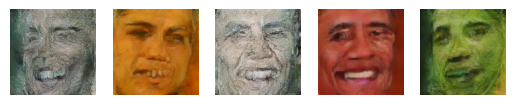

Epoch=271 | Train Loss: 0.19858762435615063
Epoch=272 | Train Loss: 0.14327015075832605
Epoch=273 | Train Loss: 0.14456116408109665
Epoch=274 | Train Loss: 0.17023872770369053
Epoch=275 | Train Loss: 0.14305176120251417
Epoch=276 | Train Loss: 0.14467143127694726
Epoch=277 | Train Loss: 0.12542502209544182
Epoch=278 | Train Loss: 0.1458952920511365
Epoch=279 | Train Loss: 0.1791868731379509
Epoch=280 | Train Loss: 0.17126857209950686
tensor([0, 1, 1, 2, 0], device='cuda:0')


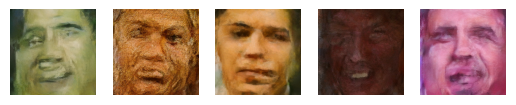

Epoch=281 | Train Loss: 0.13217609841376543
Epoch=282 | Train Loss: 0.1518213590607047
Epoch=283 | Train Loss: 0.12305540684610605
Epoch=284 | Train Loss: 0.12019987404346466
Epoch=285 | Train Loss: 0.12098829681053758
Epoch=286 | Train Loss: 0.10248676361516118
Epoch=287 | Train Loss: 0.15411793813109398
Epoch=288 | Train Loss: 0.13581762555986643
Epoch=289 | Train Loss: 0.12615026161074638
Epoch=290 | Train Loss: 0.14313056122045964
tensor([2, 0, 1, 1, 1], device='cuda:0')


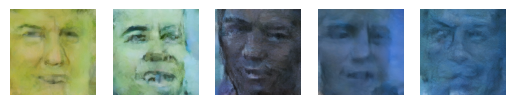

Epoch=291 | Train Loss: 0.12060194462537766
Epoch=292 | Train Loss: 0.15740549936890602
Epoch=293 | Train Loss: 0.15210922807455063
Epoch=294 | Train Loss: 0.1550205871462822
Epoch=295 | Train Loss: 0.1680376990698278
Epoch=296 | Train Loss: 0.12659717351198196
Epoch=297 | Train Loss: 0.16077414294704795
Epoch=298 | Train Loss: 0.13425393728539348
Epoch=299 | Train Loss: 0.13690163753926754
Epoch=300 | Train Loss: 0.1326748337596655
tensor([1, 0, 0, 0, 2], device='cuda:0')


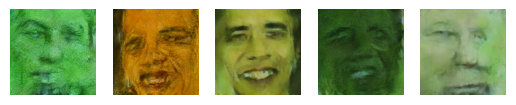

Epoch=301 | Train Loss: 0.16716651245951653
Epoch=302 | Train Loss: 0.15139975398778915
Epoch=303 | Train Loss: 0.15361173078417778
Epoch=304 | Train Loss: 0.15393025800585747
Epoch=305 | Train Loss: 0.16099926456809044
Epoch=306 | Train Loss: 0.13373425789177418
Epoch=307 | Train Loss: 0.1269176583737135
Epoch=308 | Train Loss: 0.11826778668910265
Epoch=309 | Train Loss: 0.12383622396737337
Epoch=310 | Train Loss: 0.13915199134498835
tensor([2, 2, 1, 0, 0], device='cuda:0')


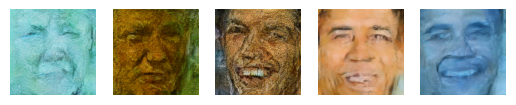

Epoch=311 | Train Loss: 0.1418441105633974
Epoch=312 | Train Loss: 0.1270531229674816
Epoch=313 | Train Loss: 0.14137556124478579
Epoch=314 | Train Loss: 0.1500723697245121
Epoch=315 | Train Loss: 0.12991173472255468
Epoch=316 | Train Loss: 0.11443130951374769
Epoch=317 | Train Loss: 0.15529397409409285
Epoch=318 | Train Loss: 0.16755778715014458
Epoch=319 | Train Loss: 0.11885935766622424
Epoch=320 | Train Loss: 0.15380748361349106
tensor([2, 1, 0, 1, 1], device='cuda:0')


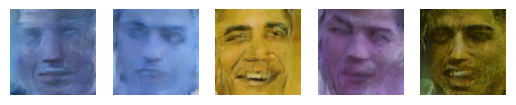

Epoch=321 | Train Loss: 0.10213352274149656
Epoch=322 | Train Loss: 0.12698385957628489
Epoch=323 | Train Loss: 0.11922996770590544
Epoch=324 | Train Loss: 0.13377317367121577
Epoch=325 | Train Loss: 0.16606692038476467
Epoch=326 | Train Loss: 0.12589571485295892
Epoch=327 | Train Loss: 0.12060780357569456
Epoch=328 | Train Loss: 0.15292018558830023
Epoch=329 | Train Loss: 0.1509732799604535
Epoch=330 | Train Loss: 0.10383388446643949
tensor([0, 1, 0, 1, 0], device='cuda:0')


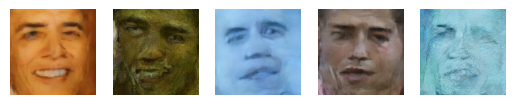

Epoch=331 | Train Loss: 0.1443489845842123
Epoch=332 | Train Loss: 0.12927486933767796
Epoch=333 | Train Loss: 0.1686973748728633
Epoch=334 | Train Loss: 0.13685065880417824
Epoch=335 | Train Loss: 0.11015921737998724
Epoch=336 | Train Loss: 0.1504406202584505
Epoch=337 | Train Loss: 0.14363726414740086
Epoch=338 | Train Loss: 0.13056990690529346
Epoch=339 | Train Loss: 0.10887716617435217
Epoch=340 | Train Loss: 0.12482594745233655
tensor([2, 2, 1, 2, 1], device='cuda:0')


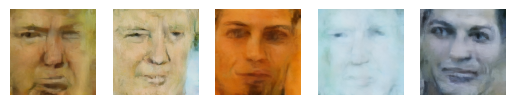

Epoch=341 | Train Loss: 0.15224110102280974
Epoch=342 | Train Loss: 0.13451211713254452
Epoch=343 | Train Loss: 0.1320800893008709
Epoch=344 | Train Loss: 0.13276630034670234
Epoch=345 | Train Loss: 0.1638475814834237
Epoch=346 | Train Loss: 0.11041502933949232
Epoch=347 | Train Loss: 0.155049963388592
Epoch=348 | Train Loss: 0.1385476873256266
Epoch=349 | Train Loss: 0.12532478384673595
Epoch=350 | Train Loss: 0.10944964922964573
tensor([2, 1, 0, 0, 0], device='cuda:0')


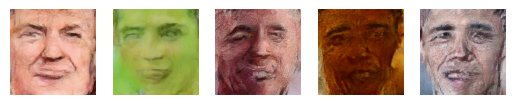

Epoch=351 | Train Loss: 0.14625548291951418
Epoch=352 | Train Loss: 0.15875663701444864
Epoch=353 | Train Loss: 0.17399259936064482
Epoch=354 | Train Loss: 0.1347028659656644
Epoch=355 | Train Loss: 0.09169476106762886
Epoch=356 | Train Loss: 0.14883053302764893
Epoch=357 | Train Loss: 0.149901129771024
Epoch=358 | Train Loss: 0.12368256878107786
Epoch=359 | Train Loss: 0.11886768229305744
Epoch=360 | Train Loss: 0.13364151492714882
tensor([2, 0, 1, 0, 0], device='cuda:0')


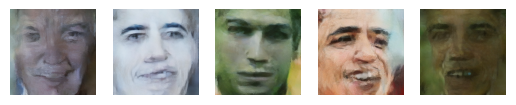

Epoch=361 | Train Loss: 0.1482349494472146
Epoch=362 | Train Loss: 0.16653116513043642
Epoch=363 | Train Loss: 0.10517637711018324
Epoch=364 | Train Loss: 0.1408873237669468
Epoch=365 | Train Loss: 0.11603696551173925
Epoch=366 | Train Loss: 0.1094083497300744
Epoch=367 | Train Loss: 0.11182525381445885
Epoch=368 | Train Loss: 0.13802682515233755
Epoch=369 | Train Loss: 0.12271712627261877
Epoch=370 | Train Loss: 0.12455388996750116
tensor([1, 2, 0, 2, 1], device='cuda:0')


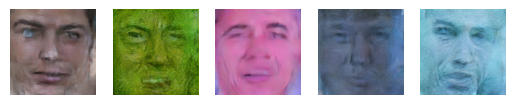

Epoch=371 | Train Loss: 0.11787353083491325
Epoch=372 | Train Loss: 0.15242569195106626
Epoch=373 | Train Loss: 0.1195273045450449
Epoch=374 | Train Loss: 0.1541231432929635
Epoch=375 | Train Loss: 0.12456654664129019
Epoch=376 | Train Loss: 0.12466354202479124
Epoch=377 | Train Loss: 0.12234751088544726
Epoch=378 | Train Loss: 0.1640497362241149
Epoch=379 | Train Loss: 0.1258087707683444
Epoch=380 | Train Loss: 0.11179781798273325
tensor([1, 2, 2, 1, 1], device='cuda:0')


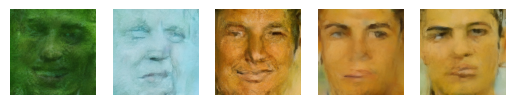

Epoch=381 | Train Loss: 0.12984662782400846
Epoch=382 | Train Loss: 0.12925339629873633
Epoch=383 | Train Loss: 0.1566945668309927
Epoch=384 | Train Loss: 0.1316091539338231
Epoch=385 | Train Loss: 0.13978553097695112
Epoch=386 | Train Loss: 0.16249504406005144
Epoch=387 | Train Loss: 0.12355232983827591
Epoch=388 | Train Loss: 0.129194141831249
Epoch=389 | Train Loss: 0.11954279709607363
Epoch=390 | Train Loss: 0.11921672150492668
tensor([1, 2, 0, 1, 1], device='cuda:0')


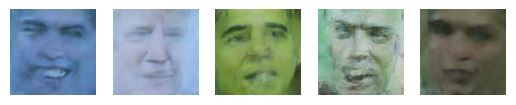

Epoch=391 | Train Loss: 0.10987134464085102
Epoch=392 | Train Loss: 0.14122854359447956
Epoch=393 | Train Loss: 0.1328284703195095
Epoch=394 | Train Loss: 0.13496687170118093
Epoch=395 | Train Loss: 0.1540601011365652
Epoch=396 | Train Loss: 0.12185542937368155
Epoch=397 | Train Loss: 0.13109854189679027
Epoch=398 | Train Loss: 0.1231562034226954
Epoch=399 | Train Loss: 0.12351799383759499
Epoch=400 | Train Loss: 0.12459179945290089
tensor([0, 0, 1, 0, 1], device='cuda:0')


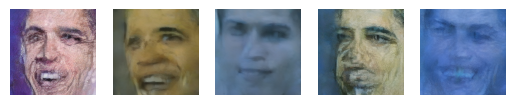

Epoch=401 | Train Loss: 0.10377550008706748
Epoch=402 | Train Loss: 0.13651317590847611
Epoch=403 | Train Loss: 0.13113912008702755
Epoch=404 | Train Loss: 0.12007670942693949
Epoch=405 | Train Loss: 0.1540713319554925
Epoch=406 | Train Loss: 0.13410483673214912
Epoch=407 | Train Loss: 0.10054415254853666
Epoch=408 | Train Loss: 0.10369560588151217
Epoch=409 | Train Loss: 0.13452500943094492
Epoch=410 | Train Loss: 0.1047480208799243
tensor([1, 1, 2, 2, 2], device='cuda:0')


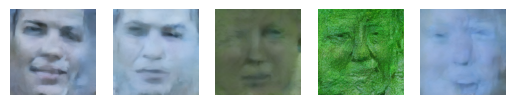

Epoch=411 | Train Loss: 0.14280619286000729
Epoch=412 | Train Loss: 0.13215204747393727
Epoch=413 | Train Loss: 0.1609818059951067
Epoch=414 | Train Loss: 0.1224225526675582
Epoch=415 | Train Loss: 0.1231006640009582
Epoch=416 | Train Loss: 0.11974753951653838
Epoch=417 | Train Loss: 0.11856290744617581
Epoch=418 | Train Loss: 0.11406991118565202
Epoch=419 | Train Loss: 0.14781342446804047
Epoch=420 | Train Loss: 0.14260146766901016
tensor([1, 1, 0, 2, 2], device='cuda:0')


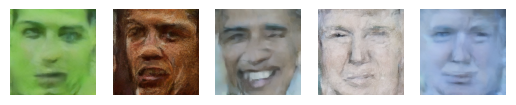

Epoch=421 | Train Loss: 0.12211602460592985
Epoch=422 | Train Loss: 0.11340515548363328
Epoch=423 | Train Loss: 0.17985032312572002
Epoch=424 | Train Loss: 0.12274390971288085
Epoch=425 | Train Loss: 0.16356122959405184
Epoch=426 | Train Loss: 0.196170162409544
Epoch=427 | Train Loss: 0.12298768945038319
Epoch=428 | Train Loss: 0.13001456763595343
Epoch=429 | Train Loss: 0.10610849037766457
Epoch=430 | Train Loss: 0.09277771599590778
tensor([0, 2, 1, 2, 1], device='cuda:0')


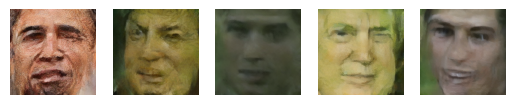

Epoch=431 | Train Loss: 0.12220811005681753
Epoch=432 | Train Loss: 0.10198682639747858
Epoch=433 | Train Loss: 0.10049811191856861
Epoch=434 | Train Loss: 0.13306949008256197
Epoch=435 | Train Loss: 0.11520484695211053
Epoch=436 | Train Loss: 0.11646206211298704
Epoch=437 | Train Loss: 0.12713458528742194
Epoch=438 | Train Loss: 0.11553360940888524
Epoch=439 | Train Loss: 0.10280127311125398
Epoch=440 | Train Loss: 0.13507379591464996
tensor([2, 2, 0, 0, 0], device='cuda:0')


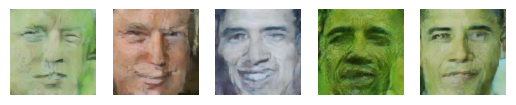

Epoch=441 | Train Loss: 0.1362125496380031
Epoch=442 | Train Loss: 0.1554252770729363
Epoch=443 | Train Loss: 0.12770199682563543
Epoch=444 | Train Loss: 0.10799327865242958
Epoch=445 | Train Loss: 0.09286516904830933
Epoch=446 | Train Loss: 0.11956862779334188
Epoch=447 | Train Loss: 0.13895502593368292
Epoch=448 | Train Loss: 0.09518665168434381
Epoch=449 | Train Loss: 0.1404502335935831
Epoch=450 | Train Loss: 0.11501108109951019
tensor([2, 1, 2, 0, 0], device='cuda:0')


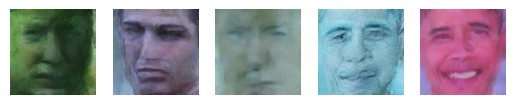

Epoch=451 | Train Loss: 0.09903491148725152
Epoch=452 | Train Loss: 0.1007387638092041
Epoch=453 | Train Loss: 0.13209213968366385
Epoch=454 | Train Loss: 0.1112928120419383
Epoch=455 | Train Loss: 0.13755394984036684
Epoch=456 | Train Loss: 0.11693891976028681
Epoch=457 | Train Loss: 0.11159506440162659
Epoch=458 | Train Loss: 0.10154011845588684
Epoch=459 | Train Loss: 0.1278365645557642
Epoch=460 | Train Loss: 0.09502226673066616
tensor([1, 0, 2, 2, 1], device='cuda:0')


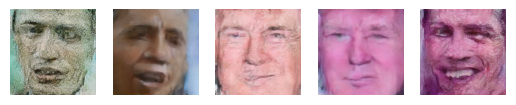

Epoch=461 | Train Loss: 0.12137830164283514
Epoch=462 | Train Loss: 0.11960356589406729
Epoch=463 | Train Loss: 0.10390318697318435
Epoch=464 | Train Loss: 0.13898800546303391
Epoch=465 | Train Loss: 0.11866417457349598
Epoch=466 | Train Loss: 0.09143076092004776
Epoch=467 | Train Loss: 0.09691113792359829
Epoch=468 | Train Loss: 0.13521170429885387
Epoch=469 | Train Loss: 0.11188655160367489
Epoch=470 | Train Loss: 0.1279774666763842
tensor([2, 1, 2, 0, 0], device='cuda:0')


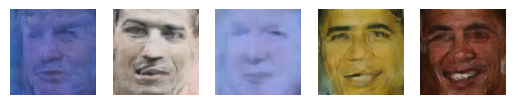

Epoch=471 | Train Loss: 0.1000928960274905
Epoch=472 | Train Loss: 0.09488624520599842
Epoch=473 | Train Loss: 0.13044958049431443
Epoch=474 | Train Loss: 0.12348158890381455
Epoch=475 | Train Loss: 0.12739569740369916
Epoch=476 | Train Loss: 0.10919299628585577
Epoch=477 | Train Loss: 0.10316050332039595
Epoch=478 | Train Loss: 0.09845481719821692
Epoch=479 | Train Loss: 0.10115225007757545
Epoch=480 | Train Loss: 0.11942265159450471
tensor([1, 2, 2, 2, 1], device='cuda:0')


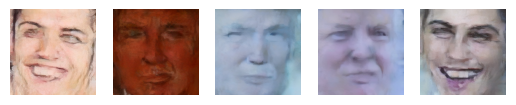

Epoch=481 | Train Loss: 0.14059794880449772
Epoch=482 | Train Loss: 0.10380253102630377
Epoch=483 | Train Loss: 0.12968844966962934
Epoch=484 | Train Loss: 0.13595974445343018
Epoch=485 | Train Loss: 0.10432386957108974
Epoch=486 | Train Loss: 0.1216934029944241
Epoch=487 | Train Loss: 0.1117523955181241
Epoch=488 | Train Loss: 0.10994974337518215
Epoch=489 | Train Loss: 0.1471259887330234
Epoch=490 | Train Loss: 0.08646892476826906
tensor([2, 1, 2, 2, 0], device='cuda:0')


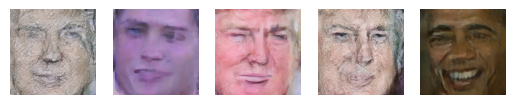

Epoch=491 | Train Loss: 0.09027469856664538
Epoch=492 | Train Loss: 0.12501120660454035
Epoch=493 | Train Loss: 0.12339131254702806
Epoch=494 | Train Loss: 0.09207635978236794
Epoch=495 | Train Loss: 0.10485091106966138
Epoch=496 | Train Loss: 0.12872764095664024
Epoch=497 | Train Loss: 0.09924772987142205
Epoch=498 | Train Loss: 0.11583389015868306
Epoch=499 | Train Loss: 0.10237638466060162
Epoch=500 | Train Loss: 0.14992220140993595
tensor([0, 2, 1, 1, 2], device='cuda:0')


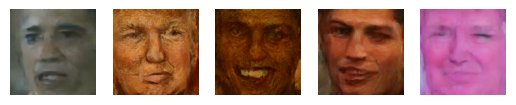

Epoch=501 | Train Loss: 0.08584853122010827
Epoch=502 | Train Loss: 0.12078607175499201
Epoch=503 | Train Loss: 0.10732588591054082
Epoch=504 | Train Loss: 0.09374883119016886
Epoch=505 | Train Loss: 0.10255189519375563
Epoch=506 | Train Loss: 0.10296272998675704
Epoch=507 | Train Loss: 0.09430812997743487
Epoch=508 | Train Loss: 0.11563096707686782
Epoch=509 | Train Loss: 0.1127445176243782
Epoch=510 | Train Loss: 0.10353862401098013
tensor([0, 1, 2, 1, 0], device='cuda:0')


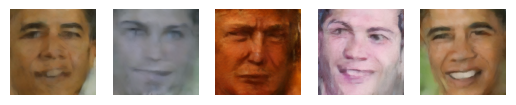

Epoch=511 | Train Loss: 0.1399777065962553
Epoch=512 | Train Loss: 0.08050888613797724
Epoch=513 | Train Loss: 0.12111816555261612
Epoch=514 | Train Loss: 0.0916187628172338
Epoch=515 | Train Loss: 0.08784318761900067
Epoch=516 | Train Loss: 0.09188719792291522
Epoch=517 | Train Loss: 0.09425717196427286
Epoch=518 | Train Loss: 0.08770981291308999
Epoch=519 | Train Loss: 0.09006096422672272
Epoch=520 | Train Loss: 0.1281952355057001
tensor([0, 0, 2, 0, 2], device='cuda:0')


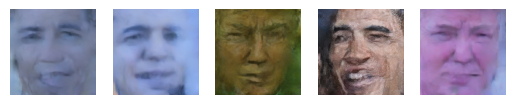

Epoch=521 | Train Loss: 0.11193715361878276
Epoch=522 | Train Loss: 0.12055352469906211
Epoch=523 | Train Loss: 0.10773418331518769
Epoch=524 | Train Loss: 0.10483605251647532
Epoch=525 | Train Loss: 0.09772867290303111
Epoch=526 | Train Loss: 0.10503970412537456
Epoch=527 | Train Loss: 0.11996195605024695
Epoch=528 | Train Loss: 0.0855134017765522
Epoch=529 | Train Loss: 0.11242932034656405
Epoch=530 | Train Loss: 0.13036096841096878
tensor([0, 2, 0, 2, 0], device='cuda:0')


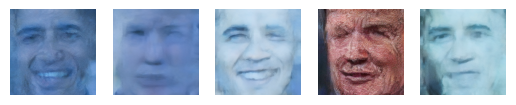

Epoch=531 | Train Loss: 0.09073351928964257
Epoch=532 | Train Loss: 0.08392269886098802
Epoch=533 | Train Loss: 0.0931290746666491
Epoch=534 | Train Loss: 0.08653283584862947
Epoch=535 | Train Loss: 0.12551651149988174
Epoch=536 | Train Loss: 0.10601928806863725
Epoch=537 | Train Loss: 0.11243991926312447
Epoch=538 | Train Loss: 0.10869552008807659
Epoch=539 | Train Loss: 0.10556956194341183
Epoch=540 | Train Loss: 0.09447364835068583
tensor([1, 0, 1, 1, 1], device='cuda:0')


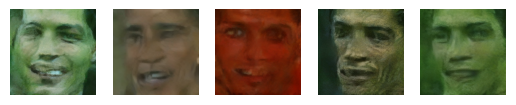

Epoch=541 | Train Loss: 0.08501473069190979
Epoch=542 | Train Loss: 0.11639218777418137
Epoch=543 | Train Loss: 0.09701940324157476
Epoch=544 | Train Loss: 0.11479752045124769
Epoch=545 | Train Loss: 0.08817101106978953
Epoch=546 | Train Loss: 0.11566721461713314
Epoch=547 | Train Loss: 0.07819770812056959
Epoch=548 | Train Loss: 0.11269062478095293
Epoch=549 | Train Loss: 0.11105570802465081
Epoch=550 | Train Loss: 0.11210540775209665
tensor([0, 1, 0, 2, 0], device='cuda:0')


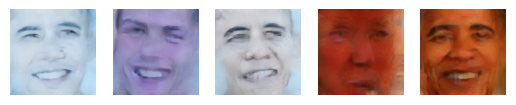

Epoch=551 | Train Loss: 0.12917280523106456
Epoch=552 | Train Loss: 0.12697334168478847
Epoch=553 | Train Loss: 0.10442930040881038
Epoch=554 | Train Loss: 0.10600890079513192
Epoch=555 | Train Loss: 0.10509443283081055
Epoch=556 | Train Loss: 0.08040601457469165
Epoch=557 | Train Loss: 0.07723831478506327
Epoch=558 | Train Loss: 0.07707651588134468
Epoch=559 | Train Loss: 0.10641874140128493
Epoch=560 | Train Loss: 0.09315544459968805
tensor([0, 0, 2, 0, 1], device='cuda:0')


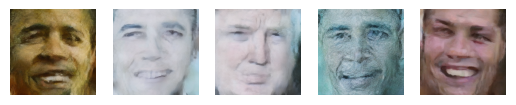

Epoch=561 | Train Loss: 0.09010582929477096
Epoch=562 | Train Loss: 0.07961219036951661
Epoch=563 | Train Loss: 0.09484124183654785
Epoch=564 | Train Loss: 0.11151992250233889
Epoch=565 | Train Loss: 0.09666508389636874
Epoch=566 | Train Loss: 0.10458841547369957
Epoch=567 | Train Loss: 0.11048137117177248
Epoch=568 | Train Loss: 0.09611594770103693
Epoch=569 | Train Loss: 0.12713441625237465
Epoch=570 | Train Loss: 0.1281273104250431
tensor([1, 1, 0, 2, 0], device='cuda:0')


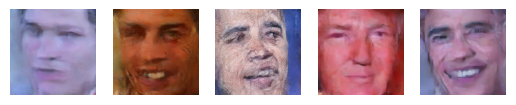

Epoch=571 | Train Loss: 0.10116271395236254
Epoch=572 | Train Loss: 0.11541764438152313
Epoch=573 | Train Loss: 0.08348107617348433
Epoch=574 | Train Loss: 0.0961195481941104
Epoch=575 | Train Loss: 0.11994325369596481
Epoch=576 | Train Loss: 0.11364877014420927
Epoch=577 | Train Loss: 0.0834884736686945
Epoch=578 | Train Loss: 0.08870808174833655
Epoch=579 | Train Loss: 0.09541034372523427
Epoch=580 | Train Loss: 0.09392674406990409
tensor([1, 1, 1, 0, 1], device='cuda:0')


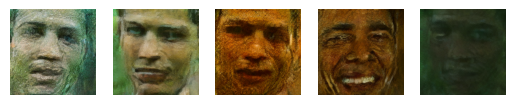

Epoch=581 | Train Loss: 0.09002327360212803
Epoch=582 | Train Loss: 0.08594912104308605
Epoch=583 | Train Loss: 0.10536233521997929
Epoch=584 | Train Loss: 0.09126279689371586
Epoch=585 | Train Loss: 0.0928287273272872
Epoch=586 | Train Loss: 0.0994641506113112
Epoch=587 | Train Loss: 0.10300714010372758
Epoch=588 | Train Loss: 0.09955699695274234
Epoch=589 | Train Loss: 0.08944377209991217
Epoch=590 | Train Loss: 0.08736072876490653
tensor([0, 1, 2, 2, 0], device='cuda:0')


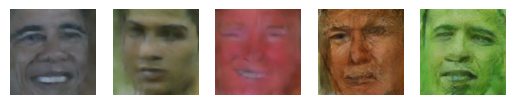

Epoch=591 | Train Loss: 0.09238918730989099
Epoch=592 | Train Loss: 0.1052867469843477
Epoch=593 | Train Loss: 0.09869642648845911
Epoch=594 | Train Loss: 0.09867814043536782
Epoch=595 | Train Loss: 0.10313797416165471
Epoch=596 | Train Loss: 0.09660157514736056
Epoch=597 | Train Loss: 0.06918309396132827
Epoch=598 | Train Loss: 0.10955776134505868
Epoch=599 | Train Loss: 0.09202345740050077
Epoch=600 | Train Loss: 0.11518613947555423
tensor([1, 2, 2, 1, 0], device='cuda:0')


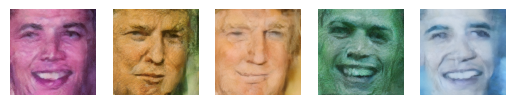

Epoch=601 | Train Loss: 0.1331279994919896
Epoch=602 | Train Loss: 0.08695163251832128
Epoch=603 | Train Loss: 0.09223724389448762
Epoch=604 | Train Loss: 0.07430211640894413
Epoch=605 | Train Loss: 0.08022131130564958
Epoch=606 | Train Loss: 0.10267992317676544
Epoch=607 | Train Loss: 0.10708111198619008
Epoch=608 | Train Loss: 0.12230495922267437
Epoch=609 | Train Loss: 0.09613842749968171
Epoch=610 | Train Loss: 0.08630918292328715
tensor([2, 0, 1, 0, 2], device='cuda:0')


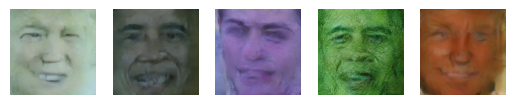

Epoch=611 | Train Loss: 0.08283645892515779
Epoch=612 | Train Loss: 0.09424733836203814
Epoch=613 | Train Loss: 0.09831375861540437
Epoch=614 | Train Loss: 0.09230143204331398
Epoch=615 | Train Loss: 0.09835035633295774
Epoch=616 | Train Loss: 0.11468418780714273
Epoch=617 | Train Loss: 0.12390756700187922
Epoch=618 | Train Loss: 0.08926673326641321
Epoch=619 | Train Loss: 0.08560995850712061
Epoch=620 | Train Loss: 0.10138222901150584
tensor([2, 0, 0, 0, 2], device='cuda:0')


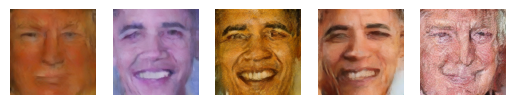

Epoch=621 | Train Loss: 0.08920608181506395
Epoch=622 | Train Loss: 0.1349669871851802
Epoch=623 | Train Loss: 0.1326288552954793
Epoch=624 | Train Loss: 0.08238360099494457
Epoch=625 | Train Loss: 0.10948541341349483
Epoch=626 | Train Loss: 0.10696798143908381
Epoch=627 | Train Loss: 0.10885653831064701
Epoch=628 | Train Loss: 0.10416908236220479
Epoch=629 | Train Loss: 0.0888259969651699
Epoch=630 | Train Loss: 0.10643176082521677
tensor([2, 0, 1, 2, 2], device='cuda:0')


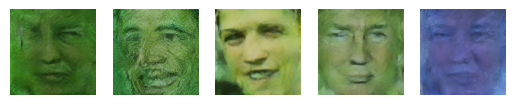

Epoch=631 | Train Loss: 0.08008355041965842
Epoch=632 | Train Loss: 0.09132420923560858
Epoch=633 | Train Loss: 0.10924264742061496
Epoch=634 | Train Loss: 0.1471536671742797
Epoch=635 | Train Loss: 0.10541904787532985
Epoch=636 | Train Loss: 0.09659644961357117
Epoch=637 | Train Loss: 0.079399055801332
Epoch=638 | Train Loss: 0.08003449812531471
Epoch=639 | Train Loss: 0.1205270173959434
Epoch=640 | Train Loss: 0.0762382848188281
tensor([1, 2, 2, 0, 1], device='cuda:0')


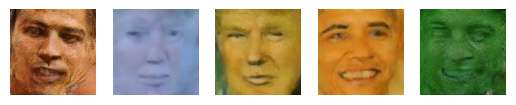

Epoch=641 | Train Loss: 0.08687984046991915
Epoch=642 | Train Loss: 0.0942109888419509
Epoch=643 | Train Loss: 0.09329136181622744
Epoch=644 | Train Loss: 0.07438765349797904
Epoch=645 | Train Loss: 0.09837823733687401
Epoch=646 | Train Loss: 0.10457893600687385
Epoch=647 | Train Loss: 0.07038278761319816
Epoch=648 | Train Loss: 0.08120447723194957
Epoch=649 | Train Loss: 0.07386261667124927
Epoch=650 | Train Loss: 0.0900350627489388
tensor([2, 1, 0, 1, 1], device='cuda:0')


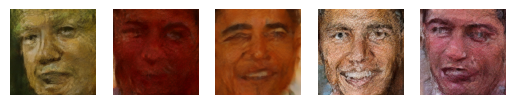

Epoch=651 | Train Loss: 0.07091126823797822
Epoch=652 | Train Loss: 0.08887290256097913
Epoch=653 | Train Loss: 0.12667922116816044
Epoch=654 | Train Loss: 0.09970412962138653
Epoch=655 | Train Loss: 0.08896362222731113
Epoch=656 | Train Loss: 0.11716975783929229
Epoch=657 | Train Loss: 0.09349551214836538
Epoch=658 | Train Loss: 0.1289440682157874
Epoch=659 | Train Loss: 0.08102191844955087
Epoch=660 | Train Loss: 0.08706645388156176
tensor([1, 0, 2, 2, 1], device='cuda:0')


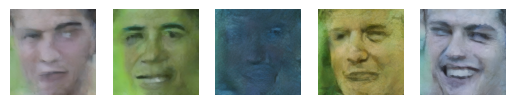

Epoch=661 | Train Loss: 0.0816638832911849
Epoch=662 | Train Loss: 0.11562885995954275
Epoch=663 | Train Loss: 0.10409138863906264
Epoch=664 | Train Loss: 0.08121702983044088
Epoch=665 | Train Loss: 0.06802059547044337
Epoch=666 | Train Loss: 0.07653194456361234
Epoch=667 | Train Loss: 0.07471915800124407
Epoch=668 | Train Loss: 0.0921744555234909
Epoch=669 | Train Loss: 0.11000603483989835
Epoch=670 | Train Loss: 0.11590261617675424
tensor([2, 0, 0, 0, 0], device='cuda:0')


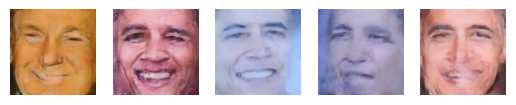

Epoch=671 | Train Loss: 0.08780807675793767
Epoch=672 | Train Loss: 0.10816647345200181
Epoch=673 | Train Loss: 0.09865370066836476
Epoch=674 | Train Loss: 0.09931649174541235
Epoch=675 | Train Loss: 0.09266874776221812
Epoch=676 | Train Loss: 0.10376511700451374
Epoch=677 | Train Loss: 0.07743853703141212
Epoch=678 | Train Loss: 0.08645129879005253
Epoch=679 | Train Loss: 0.08013459201902151
Epoch=680 | Train Loss: 0.08462861808948219
tensor([1, 1, 0, 2, 2], device='cuda:0')


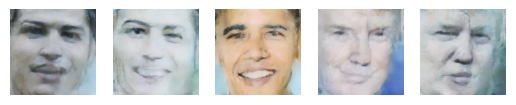

Epoch=681 | Train Loss: 0.06537654157727957
Epoch=682 | Train Loss: 0.09351655235514045
Epoch=683 | Train Loss: 0.09444296453148127
Epoch=684 | Train Loss: 0.06954800966195762
Epoch=685 | Train Loss: 0.09269938571378589
Epoch=686 | Train Loss: 0.09123646770603955
Epoch=687 | Train Loss: 0.11392102297395468
Epoch=688 | Train Loss: 0.09472328214906156
Epoch=689 | Train Loss: 0.07026800606399775
Epoch=690 | Train Loss: 0.08783129462972283
tensor([0, 2, 1, 0, 2], device='cuda:0')


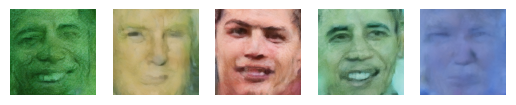

Epoch=691 | Train Loss: 0.08323899772949517
Epoch=692 | Train Loss: 0.086550273001194
Epoch=693 | Train Loss: 0.09365918766707182
Epoch=694 | Train Loss: 0.11862523993477225
Epoch=695 | Train Loss: 0.12418783083558083
Epoch=696 | Train Loss: 0.09771075798198581
Epoch=697 | Train Loss: 0.11351015558466315
Epoch=698 | Train Loss: 0.09796182718127966
Epoch=699 | Train Loss: 0.11347484774887562
Epoch=700 | Train Loss: 0.11295286100357771
tensor([2, 0, 1, 0, 0], device='cuda:0')


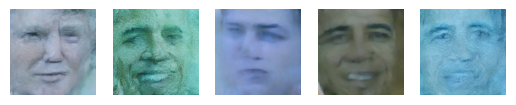

Epoch=701 | Train Loss: 0.06649499293416739
Epoch=702 | Train Loss: 0.09333254070952535
Epoch=703 | Train Loss: 0.08119494980201125
Epoch=704 | Train Loss: 0.11012250371277332
Epoch=705 | Train Loss: 0.09594722976908088
Epoch=706 | Train Loss: 0.08645393839105964
Epoch=707 | Train Loss: 0.08203968266025186
Epoch=708 | Train Loss: 0.10268406756222248
Epoch=709 | Train Loss: 0.10414058342576027
Epoch=710 | Train Loss: 0.09226591768674552
tensor([2, 1, 1, 2, 1], device='cuda:0')


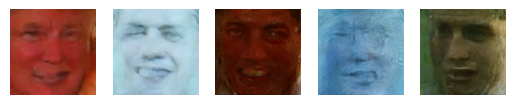

Epoch=711 | Train Loss: 0.07014816417358816
Epoch=712 | Train Loss: 0.08223388437181711
Epoch=713 | Train Loss: 0.09287012740969658
Epoch=714 | Train Loss: 0.0691251396201551
Epoch=715 | Train Loss: 0.10015142243355513
Epoch=716 | Train Loss: 0.07998397061601281
Epoch=717 | Train Loss: 0.08756185183301568
Epoch=718 | Train Loss: 0.0835517649538815
Epoch=719 | Train Loss: 0.10649741720408201
Epoch=720 | Train Loss: 0.08113099727779627
tensor([0, 1, 2, 2, 0], device='cuda:0')


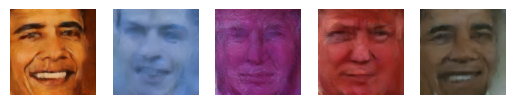

Epoch=721 | Train Loss: 0.11480828421190381
Epoch=722 | Train Loss: 0.10182886780239642
Epoch=723 | Train Loss: 0.09300284972414374
Epoch=724 | Train Loss: 0.08535339403897524
Epoch=725 | Train Loss: 0.10508315498009324
Epoch=726 | Train Loss: 0.0896271311212331
Epoch=727 | Train Loss: 0.1071599880233407
Epoch=728 | Train Loss: 0.08505170024000108
Epoch=729 | Train Loss: 0.07516234461218119
Epoch=730 | Train Loss: 0.07580197416245937
tensor([0, 2, 2, 0, 1], device='cuda:0')


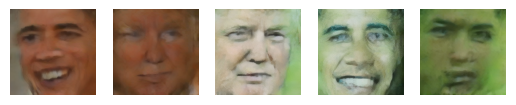

Epoch=731 | Train Loss: 0.05510841985233128
Epoch=732 | Train Loss: 0.09977934136986732
Epoch=733 | Train Loss: 0.06991427624598145
Epoch=734 | Train Loss: 0.08019671868532896
Epoch=735 | Train Loss: 0.08606207557022572
Epoch=736 | Train Loss: 0.07787902047857642
Epoch=737 | Train Loss: 0.08804749231785536
Epoch=738 | Train Loss: 0.09831483708694577
Epoch=739 | Train Loss: 0.09411733271554112
Epoch=740 | Train Loss: 0.05010384367778897
tensor([2, 0, 2, 0, 2], device='cuda:0')


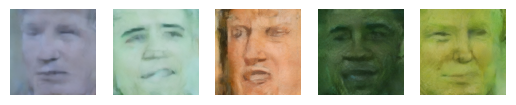

Epoch=741 | Train Loss: 0.10096662724390626
Epoch=742 | Train Loss: 0.09411603026092052
Epoch=743 | Train Loss: 0.07192827621474862
Epoch=744 | Train Loss: 0.08487042039632797
Epoch=745 | Train Loss: 0.09552946779876947
Epoch=746 | Train Loss: 0.07894446887075901
Epoch=747 | Train Loss: 0.09332271385937929
Epoch=748 | Train Loss: 0.08619321719743311
Epoch=749 | Train Loss: 0.09756752057000995
Epoch=750 | Train Loss: 0.1046262588351965
tensor([0, 2, 1, 1, 2], device='cuda:0')


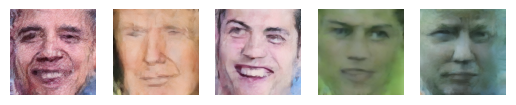

Epoch=751 | Train Loss: 0.08360240771435201
Epoch=752 | Train Loss: 0.05319245485588908
Epoch=753 | Train Loss: 0.05591708025895059
Epoch=754 | Train Loss: 0.07396471151150763
Epoch=755 | Train Loss: 0.0854134326800704
Epoch=756 | Train Loss: 0.09026097529567778
Epoch=757 | Train Loss: 0.09913529804907739
Epoch=758 | Train Loss: 0.0770707125775516
Epoch=759 | Train Loss: 0.08859028574079275
Epoch=760 | Train Loss: 0.09045432507991791
tensor([0, 2, 0, 2, 0], device='cuda:0')


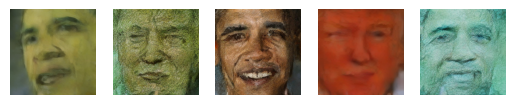

Epoch=761 | Train Loss: 0.07122079562395811
Epoch=762 | Train Loss: 0.10092079848982394
Epoch=763 | Train Loss: 0.0646749367006123
Epoch=764 | Train Loss: 0.0829937260132283
Epoch=765 | Train Loss: 0.05568254424724728
Epoch=766 | Train Loss: 0.08720891503617167
Epoch=767 | Train Loss: 0.09645329276099801
Epoch=768 | Train Loss: 0.09238078794442117
Epoch=769 | Train Loss: 0.055953047471120954
Epoch=770 | Train Loss: 0.07683213637210429
tensor([0, 2, 1, 1, 1], device='cuda:0')


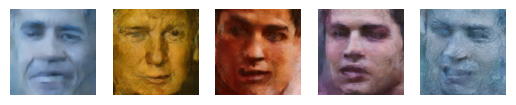

Epoch=771 | Train Loss: 0.07320685964077711
Epoch=772 | Train Loss: 0.08479830482974648
Epoch=773 | Train Loss: 0.09328256035223603
Epoch=774 | Train Loss: 0.07601442071609199
Epoch=775 | Train Loss: 0.06564561277627945
Epoch=776 | Train Loss: 0.09658712870441377
Epoch=777 | Train Loss: 0.08468824392184615
Epoch=778 | Train Loss: 0.09307783748954535
Epoch=779 | Train Loss: 0.06496035028249025
Epoch=780 | Train Loss: 0.05881934694480151
tensor([2, 1, 0, 0, 2], device='cuda:0')


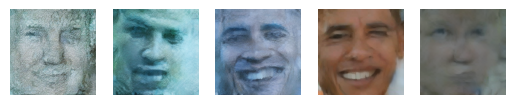

Epoch=781 | Train Loss: 0.09599625039845705
Epoch=782 | Train Loss: 0.06196692190133035
Epoch=783 | Train Loss: 0.07103279721923172
Epoch=784 | Train Loss: 0.07418485055677593
Epoch=785 | Train Loss: 0.09592852182686329
Epoch=786 | Train Loss: 0.0753156510181725
Epoch=787 | Train Loss: 0.0865233272779733
Epoch=788 | Train Loss: 0.08199770888313651
Epoch=789 | Train Loss: 0.09520495543256402
Epoch=790 | Train Loss: 0.07596792886033654
tensor([0, 0, 0, 0, 2], device='cuda:0')


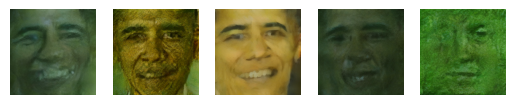

Epoch=791 | Train Loss: 0.05643643345683813
Epoch=792 | Train Loss: 0.09197742119431496
Epoch=793 | Train Loss: 0.09874236024916172
Epoch=794 | Train Loss: 0.07796643441542983
Epoch=795 | Train Loss: 0.08468992123380303
Epoch=796 | Train Loss: 0.06594246625900269
Epoch=797 | Train Loss: 0.11181355710141361
Epoch=798 | Train Loss: 0.10402666288428009
Epoch=799 | Train Loss: 0.08847938547842205
Epoch=800 | Train Loss: 0.114730270113796
tensor([0, 0, 0, 1, 0], device='cuda:0')


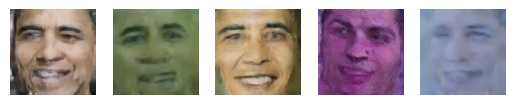

Epoch=801 | Train Loss: 0.09247372671961784
Epoch=802 | Train Loss: 0.09740153467282653
Epoch=803 | Train Loss: 0.08626915351487696
Epoch=804 | Train Loss: 0.1086094044148922
Epoch=805 | Train Loss: 0.09679673193022609
Epoch=806 | Train Loss: 0.07438623323105276
Epoch=807 | Train Loss: 0.06803438265342265
Epoch=808 | Train Loss: 0.08054410945624113
Epoch=809 | Train Loss: 0.0972424156498164
Epoch=810 | Train Loss: 0.06042591133154929
tensor([0, 0, 2, 1, 2], device='cuda:0')


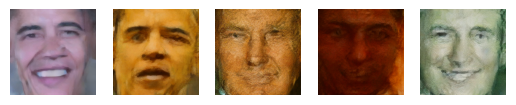

Epoch=811 | Train Loss: 0.09447174798697233
Epoch=812 | Train Loss: 0.08555203583091497
Epoch=813 | Train Loss: 0.06789821945130825
Epoch=814 | Train Loss: 0.07821797952055931
Epoch=815 | Train Loss: 0.08324074023403227
Epoch=816 | Train Loss: 0.09672128921374679
Epoch=817 | Train Loss: 0.08644331200048327
Epoch=818 | Train Loss: 0.07827473804354668
Epoch=819 | Train Loss: 0.07407297333702445
Epoch=820 | Train Loss: 0.10912657203152776
tensor([0, 1, 0, 1, 1], device='cuda:0')


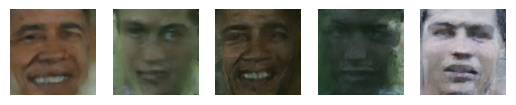

Epoch=821 | Train Loss: 0.0664298590272665
Epoch=822 | Train Loss: 0.10663029737770557
Epoch=823 | Train Loss: 0.09072993928566575
Epoch=824 | Train Loss: 0.07612929679453373
Epoch=825 | Train Loss: 0.07324268342927098
Epoch=826 | Train Loss: 0.0861482685431838
Epoch=827 | Train Loss: 0.09065512986853719
Epoch=828 | Train Loss: 0.11022420600056648
Epoch=829 | Train Loss: 0.08673048508353531
Epoch=830 | Train Loss: 0.09914572490379214
tensor([0, 0, 1, 1, 2], device='cuda:0')


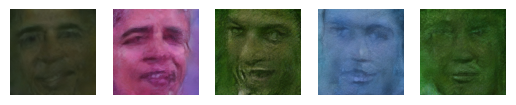

Epoch=831 | Train Loss: 0.07791632041335106
Epoch=832 | Train Loss: 0.06650822306983173
Epoch=833 | Train Loss: 0.10359518160112202
Epoch=834 | Train Loss: 0.12311993166804314
Epoch=835 | Train Loss: 0.0700514018535614
Epoch=836 | Train Loss: 0.0833671223372221
Epoch=837 | Train Loss: 0.09635042538866401
Epoch=838 | Train Loss: 0.09613683493807912
Epoch=839 | Train Loss: 0.06808743556030095
Epoch=840 | Train Loss: 0.07496917922981083
tensor([2, 2, 1, 2, 0], device='cuda:0')


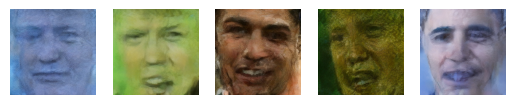

Epoch=841 | Train Loss: 0.08283575996756554
Epoch=842 | Train Loss: 0.06213018065318465
Epoch=843 | Train Loss: 0.09969949768856168
Epoch=844 | Train Loss: 0.06423794524744153
Epoch=845 | Train Loss: 0.0801294578704983
Epoch=846 | Train Loss: 0.08250371739268303
Epoch=847 | Train Loss: 0.09990566852502525
Epoch=848 | Train Loss: 0.09039044380187988
Epoch=849 | Train Loss: 0.0647388594225049
Epoch=850 | Train Loss: 0.07133924309164286
tensor([2, 1, 1, 2, 2], device='cuda:0')


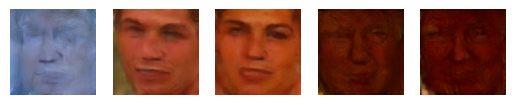

Epoch=851 | Train Loss: 0.07078877231106162
Epoch=852 | Train Loss: 0.0668889416847378
Epoch=853 | Train Loss: 0.08768131316173822
Epoch=854 | Train Loss: 0.09086620341986418
Epoch=855 | Train Loss: 0.07784413313493133
Epoch=856 | Train Loss: 0.060127458069473505
Epoch=857 | Train Loss: 0.07602450530976057
Epoch=858 | Train Loss: 0.09045038698241115
Epoch=859 | Train Loss: 0.08145646564662457
Epoch=860 | Train Loss: 0.07915526954457164
tensor([2, 1, 2, 2, 0], device='cuda:0')


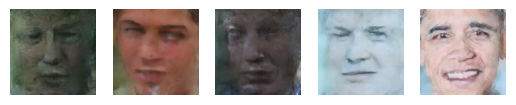

Epoch=861 | Train Loss: 0.0781092713586986
Epoch=862 | Train Loss: 0.07266831933520734
Epoch=863 | Train Loss: 0.10681050829589367
Epoch=864 | Train Loss: 0.08644277136772871
Epoch=865 | Train Loss: 0.09050015639513731
Epoch=866 | Train Loss: 0.07027462450787425
Epoch=867 | Train Loss: 0.0889239483512938
Epoch=868 | Train Loss: 0.0890428270213306
Epoch=869 | Train Loss: 0.10497559164650738
Epoch=870 | Train Loss: 0.07493073306977749
tensor([2, 2, 1, 1, 0], device='cuda:0')


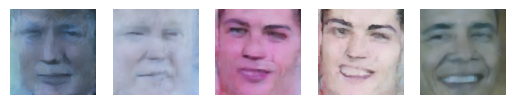

Epoch=871 | Train Loss: 0.08245599642395973
Epoch=872 | Train Loss: 0.09005335532128811
Epoch=873 | Train Loss: 0.08338942285627127
Epoch=874 | Train Loss: 0.07784736063331366
Epoch=875 | Train Loss: 0.07437421940267086
Epoch=876 | Train Loss: 0.09063608571887016
Epoch=877 | Train Loss: 0.061613483587279916
Epoch=878 | Train Loss: 0.06591646885499358
Epoch=879 | Train Loss: 0.08570559695363045
Epoch=880 | Train Loss: 0.07343989866785705
tensor([2, 1, 0, 2, 0], device='cuda:0')


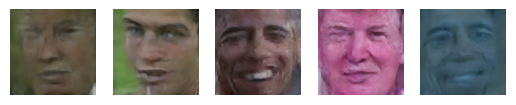

Epoch=881 | Train Loss: 0.07693213829770684
Epoch=882 | Train Loss: 0.09706183569505811
Epoch=883 | Train Loss: 0.07842967216856778
Epoch=884 | Train Loss: 0.06762870191596448
Epoch=885 | Train Loss: 0.07442125584930182
Epoch=886 | Train Loss: 0.07920233579352498
Epoch=887 | Train Loss: 0.06357370689511299
Epoch=888 | Train Loss: 0.07370507065206766
Epoch=889 | Train Loss: 0.09318158915266395
Epoch=890 | Train Loss: 0.0596040163654834
tensor([0, 0, 1, 1, 1], device='cuda:0')


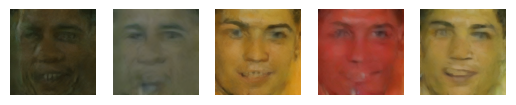

Epoch=891 | Train Loss: 0.06352221127599478
Epoch=892 | Train Loss: 0.07073817402124405
Epoch=893 | Train Loss: 0.08624923136085272
Epoch=894 | Train Loss: 0.08755086129531264
Epoch=895 | Train Loss: 0.05173764401115477
Epoch=896 | Train Loss: 0.09303807863034308
Epoch=897 | Train Loss: 0.072510268073529
Epoch=898 | Train Loss: 0.08025968610309064
Epoch=899 | Train Loss: 0.09130465146154165
Epoch=900 | Train Loss: 0.07942274492233992
tensor([1, 0, 1, 0, 2], device='cuda:0')


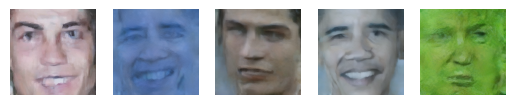

Epoch=901 | Train Loss: 0.06959821679629385
Epoch=902 | Train Loss: 0.0773334534605965
Epoch=903 | Train Loss: 0.08663893933407962
Epoch=904 | Train Loss: 0.07655675988644361
Epoch=905 | Train Loss: 0.08646456361748278
Epoch=906 | Train Loss: 0.07382382615469396
Epoch=907 | Train Loss: 0.056524315383285284
Epoch=908 | Train Loss: 0.05418892274610698
Epoch=909 | Train Loss: 0.06001166254281998
Epoch=910 | Train Loss: 0.07038173405453563
tensor([1, 1, 1, 0, 0], device='cuda:0')


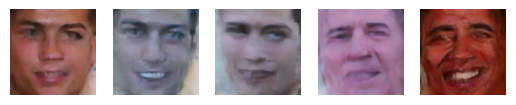

Epoch=911 | Train Loss: 0.0955236260779202
Epoch=912 | Train Loss: 0.08517372561618686
Epoch=913 | Train Loss: 0.06218311656266451
Epoch=914 | Train Loss: 0.0797731950879097
Epoch=915 | Train Loss: 0.07293207664042711
Epoch=916 | Train Loss: 0.09518180508166552
Epoch=917 | Train Loss: 0.08655096776783466
Epoch=918 | Train Loss: 0.0721853980794549
Epoch=919 | Train Loss: 0.08196587162092328
Epoch=920 | Train Loss: 0.09526559803634882
tensor([0, 2, 2, 1, 1], device='cuda:0')


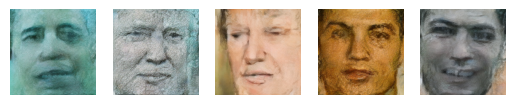

Epoch=921 | Train Loss: 0.06847057421691716
Epoch=922 | Train Loss: 0.057372858049348
Epoch=923 | Train Loss: 0.06666568689979613
Epoch=924 | Train Loss: 0.06376290903426707
Epoch=925 | Train Loss: 0.07754991273395717
Epoch=926 | Train Loss: 0.041908636689186096
Epoch=927 | Train Loss: 0.07524760393425822
Epoch=928 | Train Loss: 0.05432347720488906
Epoch=929 | Train Loss: 0.08799078175798059
Epoch=930 | Train Loss: 0.048357682884670794
tensor([2, 1, 1, 2, 0], device='cuda:0')


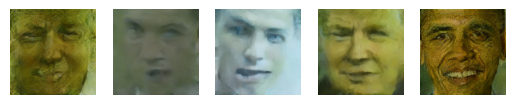

Epoch=931 | Train Loss: 0.07572545437142253
Epoch=932 | Train Loss: 0.05981326987966895
Epoch=933 | Train Loss: 0.06873705447651446
Epoch=934 | Train Loss: 0.08588142972439528
Epoch=935 | Train Loss: 0.07704971148632467
Epoch=936 | Train Loss: 0.07273142784833908
Epoch=937 | Train Loss: 0.08478128537535667
Epoch=938 | Train Loss: 0.07103546196594834
Epoch=939 | Train Loss: 0.05202044465113431
Epoch=940 | Train Loss: 0.07447965058963746
tensor([2, 0, 2, 0, 1], device='cuda:0')


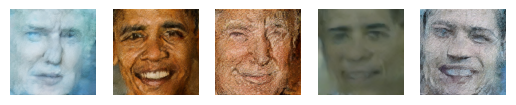

Epoch=941 | Train Loss: 0.07377252914011478
Epoch=942 | Train Loss: 0.07927196798846126
Epoch=943 | Train Loss: 0.06090330774895847
Epoch=944 | Train Loss: 0.09119203081354499
Epoch=945 | Train Loss: 0.061495621455833316
Epoch=946 | Train Loss: 0.0668793604709208
Epoch=947 | Train Loss: 0.10277494648471475
Epoch=948 | Train Loss: 0.06374946306459606
Epoch=949 | Train Loss: 0.07446109363809228
Epoch=950 | Train Loss: 0.07925890060141683
tensor([0, 2, 2, 2, 2], device='cuda:0')


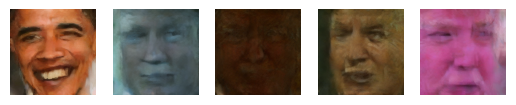

Epoch=951 | Train Loss: 0.09523940598592162
Epoch=952 | Train Loss: 0.06260022055357695
Epoch=953 | Train Loss: 0.06790984980762005
Epoch=954 | Train Loss: 0.08978995215147734
Epoch=955 | Train Loss: 0.06612564995884895
Epoch=956 | Train Loss: 0.06944132084026933
Epoch=957 | Train Loss: 0.07902586413547397
Epoch=958 | Train Loss: 0.08358427276834846
Epoch=959 | Train Loss: 0.10574714560061693
Epoch=960 | Train Loss: 0.08054045028984547
tensor([1, 1, 1, 0, 2], device='cuda:0')


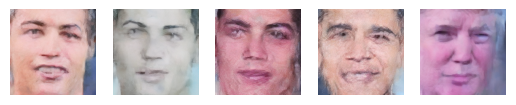

Epoch=961 | Train Loss: 0.06897198921069503
Epoch=962 | Train Loss: 0.07887308252975345
Epoch=963 | Train Loss: 0.05826670932583511
Epoch=964 | Train Loss: 0.07971480907872319
Epoch=965 | Train Loss: 0.08692611753940582
Epoch=966 | Train Loss: 0.05239951703697443
Epoch=967 | Train Loss: 0.08219476323574781
Epoch=968 | Train Loss: 0.055853446712717414
Epoch=969 | Train Loss: 0.09813967067748308
Epoch=970 | Train Loss: 0.0653952609281987
tensor([0, 0, 0, 2, 1], device='cuda:0')


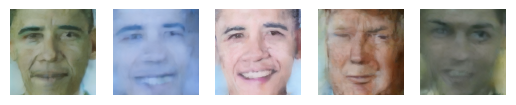

Epoch=971 | Train Loss: 0.08990768506191671
Epoch=972 | Train Loss: 0.07811827957630157
Epoch=973 | Train Loss: 0.10743631701916456
Epoch=974 | Train Loss: 0.08261215477250516
Epoch=975 | Train Loss: 0.07192661031149328
Epoch=976 | Train Loss: 0.07243652828037739
Epoch=977 | Train Loss: 0.08696007519029081
Epoch=978 | Train Loss: 0.07423133426345885
Epoch=979 | Train Loss: 0.07111452473327518
Epoch=980 | Train Loss: 0.07189640868455172
tensor([2, 2, 1, 0, 1], device='cuda:0')


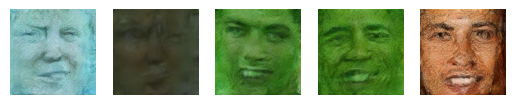

Epoch=981 | Train Loss: 0.05123606801498681
Epoch=982 | Train Loss: 0.05964721133932471
Epoch=983 | Train Loss: 0.08386943861842155
Epoch=984 | Train Loss: 0.05994047783315182
Epoch=985 | Train Loss: 0.06620413949713111
Epoch=986 | Train Loss: 0.07831078255549073
Epoch=987 | Train Loss: 0.0623424903023988
Epoch=988 | Train Loss: 0.09110094234347343
Epoch=989 | Train Loss: 0.0671187355183065
Epoch=990 | Train Loss: 0.07653401838615537
tensor([1, 1, 2, 2, 1], device='cuda:0')


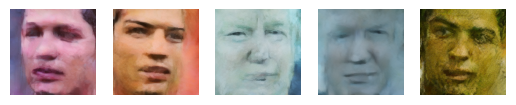

Epoch=991 | Train Loss: 0.09940675785765052
Epoch=992 | Train Loss: 0.08791052340529859
Epoch=993 | Train Loss: 0.09110931144095957
Epoch=994 | Train Loss: 0.07387310219928622
Epoch=995 | Train Loss: 0.07430404867045581
Epoch=996 | Train Loss: 0.06702773296274245
Epoch=997 | Train Loss: 0.10904686991125345
Epoch=998 | Train Loss: 0.06420327653177083
Epoch=999 | Train Loss: 0.04377005808055401


In [17]:
train(unet, epochs=1000)

In [25]:
def plot_losses(losses):
    batches = range(1, len(losses) + 1)

    plt.plot(batches, losses, label="Training Loss")
    
    plt.title("Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

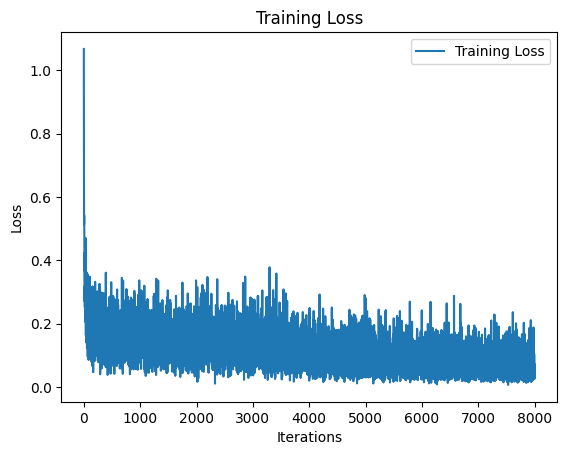

In [26]:
plot_losses(train_losses)

In [20]:
# torch.save(unet.state_dict(), "./face_unet.pth")

In [7]:
unet.load_state_dict(torch.load("./face_unet.pth"))

<All keys matched successfully>

In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [9]:
def generate_image(model):
    model.eval()
    noisy_images = torch.randn((5, 4, 32, 32)).to(device)
    labels = torch.randint(3, size=(noisy_images[:5].shape[0],)).to(device)

    for timestep in noise_scheduler.timesteps:
        with torch.inference_mode():
            noise = model(noisy_images, timestep, labels).sample
        noisy_images = noise_scheduler.step(noise, timestep, noisy_images).prev_sample

    images = latents_to_pil(noisy_images)
    fig = plt.figure()
    print(labels)
    for i in range(1, len(images)+1):
        fig.add_subplot(1, 5, i)
        plt.imshow(images[i-1])
        plt.axis("off")
    plt.show()  

tensor([2, 2, 2, 2, 2], device='cuda:0')


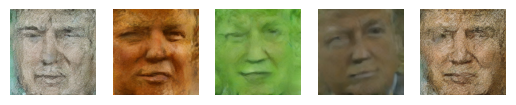

In [10]:
generate_image(unet)